In [376]:
#全部代码 可用


In [37]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from scipy.signal import butter, lfilter
import librosa, librosa.display
from scipy.signal import hilbert, chirp
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import glob
from brian2 import *
from brian2hears import *
from tqdm.notebook import tqdm
%matplotlib inline

# noise vocoded speech

# 噪音
from __future__ import division, print_function
import numpy as np
from numpy import (arange, pi, zeros)
import scipy as sp
from scipy.io import wavfile
import scipy.signal
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, Audio
import librosa
#plt.style.use('bmh')
import math
%matplotlib inline



In [38]:
def third_octave_bounds(cf):
    third_octave_ratio = 2 ** (1/6)  # 2 * 1/6 = 1/3
    return np.array([cf / third_octave_ratio, cf * third_octave_ratio])
from scipy.signal import lfilter

def design_filter(bounds, fs):
    return sp.signal.butter(4, bounds * 2 / fs, btype='bandpass')

def octave_spaced_frequencies(low, high):
    number_of_octaves = np.log2(high) - np.log2(low)
    return low * 2 ** arange(number_of_octaves)
def design_filterbank(center_frequencies, fs):
    boundaries = [third_octave_bounds(cf) for cf in center_frequencies]
    return [design_filter(bounds, fs) for bounds in boundaries]
def apply_filterbank(x, center_frequencies, fs):
    n_samples = x.shape[-1]
    n_channels = len(center_frequencies)
    
    coefficients = design_filterbank(center_frequencies, fs)
    y = zeros((n_channels, n_samples))
    for idx, (b, a) in enumerate(coefficients):
        y[idx] = lfilter(b, a, x)
    return y

def extract_envelope(x, cutoff=20, order=1):
    envelope = np.abs(x)
    b, a = sp.signal.butter(order, cutoff * 2 / fs)
    low_pass_filtered_envelope = sp.signal.lfilter(b, a, envelope)
    return low_pass_filtered_envelope

# 提取低频震荡的 两种手法 应该是 
# 1 20hz的低筒滤波
# 2 那个技术的 
def reshape(n_channel,duration,signal):  
    
    duration = duration
    #ms
    
    sample_points = int(duration/1000*fs)

    to_pad = math.ceil(len(x)/sample_points) * sample_points

    length = abs(len(x) - to_pad)

    x_padded = np.pad(signal, ((0, 0), (0, length)),constant_values=(0, 0))
    
    x_seg = x_padded.reshape(n_channel, math.ceil(len(x)/sample_points),sample_points)
    
    return x_seg, x_padded, to_pad

def normalized_all(n_channel,filtered_s):
    plane_all = np.zeros((n_channel, filtered_s.shape[-1]*filtered_s.shape[-2]))
    temp = filtered_s
    for i in range(temp.shape[0]):
        x_signal = temp[i]
        #
        plane = np.zeros((filtered_s.shape[-2], filtered_s.shape[-1]))
        for j in range(x_signal.shape[0]):
            tp = [(x_signal[j].mean()) for i in x_signal[j]]
            plane[j] = tp
            mean_s = plane.flatten()
        plane_all[i] = mean_s
    return plane_all

def normalized_parts(n_channel,filtered_s):
    plane_all = np.zeros((n_channel, filtered_s.shape[-1]*filtered_s.shape[-2]))
    temp = filtered_s
    for i in range(temp.shape[0]):
        # center frequency 决定
        if i <= 8 : 
            x_signal = temp[i]
            plane = np.zeros((filtered_s.shape[-2], filtered_s.shape[-1]))
            for j in range(x_signal.shape[0]):
                tp = [(x_signal[j].mean()) for i in x_signal[j]]
                plane[j] = tp
                mean_s = plane.flatten()
            plane_all[i] = mean_s
        else:
            x_signal = temp[i]
            plane_all[i] = x_signal.flatten()
            
    return plane_all


def compare_spectrogram(x, y, fs, cmap):
    """Plots spectrogram of x, the original, and y, the modified signal."""
    fig, axes = plt.subplots(2, 1, sharey=True, figsize=(10, 8))

    p_x, *_, im  = axes[0].specgram(x, cmap=cmap, Fs=fs)
    vmin, vmax = 10 * np.log10([np.min(p_x), np.max(p_x)])
    _ = axes[1].specgram(y, cmap=cmap, Fs=fs, vmin=vmin, vmax=vmax)
    #_ = axes[2].specgram(vocoded_cheese, cmap='Greys', Fs=fs, vmin=vmin, vmax=vmax)
    axes[0].set_title('Original')
    axes[1].set_title('Mosaic Modified')
    #axes[2].set_title('NV Modified')
    for ax in axes:
        #ax.set_xlabel('Time (s)')
        ax.grid(False)
    axes[0].set_ylabel('Frequency (Hz)')
    #cbar = fig.colorbar(im)
    #cbar.ax.set_ylabel('Magnitude (dB)')
    fig.tight_layout()
    #fig.savefig('ddc.svg')

In [39]:
file = 'wav/060.wav'  ## demo _ jp.wav

x,fs = librosa.load(file,sr=16000)

sound = loadsound(file)
#x, index = librosa.effects.trim(sound,top_db= 20)
cf = erbspace(0*Hz,8*kHz, 20)
b1 = 1.019

In [45]:
n_channels = len(cf)
# 几个滤波器 
n_samples = x.shape[-1]
# 获取sample的数量

noise = np.random.randn(n_samples) 

#noise = numpy.random.normal(mean, std, size=n_samples)

noise_2_filter = Sound(noise, samplerate=16*kHz)

gammatone = Gammatone(sound, cf, b=b1)
gt_mon = gammatone.process()

gammatone_noise = Gammatone(noise_2_filter, cf, b=b1)
gt_noise = gammatone_noise.process() # 终于debug了

# 滤波已经做完啦。


# 生成白噪音 

filtered_x = gt_mon.transpose()
filtered_noise = gt_noise.transpose()


# 获取 noise plant
envelope_all = np.zeros((n_channels, n_samples))


for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
    envelope = extract_envelope(x_band)
    # reshape & normalization 
    envelope_all[idx] = envelope
    
    
# 切分成一块一块的。  窗口长度 设定 
filtered_x_seg,filtered_x_all, leg = reshape(len(cf), 160, envelope_all)

# 块内 平均 
norm_x = normalized_all(len(cf),filtered_x_seg)
# 特定区域平均
#norm_x = normalized_parts(len(cf),filtered_x_seg)

# 切分噪音 （可不用）
filtered_noise_seg,filtered_noise_all, leg = reshape(len(cf), 80,filtered_noise)

#norm_noise = normalized_all(len(cf),filtered_noise_seg)

vocoded_noise = np.zeros((n_channels, leg))

for idx, (x_band, noise_band) in enumerate(zip(norm_x, filtered_noise_all)):
    # x_band = 归一化后的 包络
    # noise 归一化后的 噪音
    vocoded_noise[idx] = x_band * noise_band


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]


In [46]:
final = np.sum(vocoded_noise,axis = 0)
Audio(final,rate = fs)

# 暂时还没有 smooth 但是不影响了。

In [67]:
n_channels = len(cf)
# 几个滤波器 
n_samples = x.shape[-1]
# 获取sample的数量

noise = np.random.randn(n_samples) 

#noise = numpy.random.normal(mean, std, size=n_samples)

noise_2_filter = Sound(noise, samplerate=16*kHz)

gammatone = Gammatone(sound, cf, b=b1)
gt_mon = gammatone.process()

gammatone_noise = Gammatone(noise_2_filter, cf, b=b1)
gt_noise = gammatone_noise.process() # 终于debug了

# 滤波已经做完啦。


# 生成白噪音 

filtered_x = gt_mon.transpose()
filtered_noise = gt_noise.transpose()


# 获取 noise plant
envelope_all = np.zeros((n_channels, n_samples))


for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
    envelope = extract_envelope(x_band)
    # reshape & normalization 
    envelope_all[idx] = envelope
    
    
# 切分成一块一块的。 

filtered_x_seg,filtered_x_all, leg = reshape(len(cf), 40, envelope_all)

filtered_x_seg_ori,filtered_x_all_ori, leg_ori = reshape(len(cf), 40, filtered_x)

# 块内 平均 
norm_x = normalized_all(len(cf),filtered_x_seg)
# 特定区域平均
# norm_x = normalized_parts(len(cf),filtered_x_seg)

# 切分噪音 （可不用）
filtered_noise_seg,filtered_noise_all, leg = reshape(len(cf), 40,filtered_noise)

#norm_noise = normalized_all(len(cf),filtered_noise_seg)

vocoded_noise = np.zeros((n_channels, leg))

for idx, (x_band, noise_band) in enumerate(zip(norm_x, filtered_noise_all)):
    # x_band = 归一化后的 包络
    # noise 归一化后的 噪音
    if idx < 12 :
        vocoded_noise[idx] = x_band * noise_band
    else:
        vocoded_noise[idx] = filtered_x_all_ori[idx]


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]


In [68]:
final = np.sum(vocoded_noise,axis = 0)
Audio(final,rate = fs)

# 暂时还没有 smooth 但是不影响了。

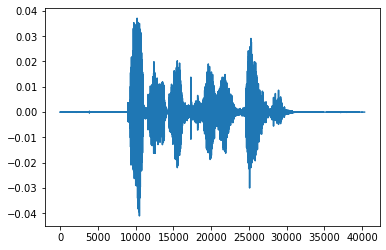

In [69]:
plt.plot(final)

In [70]:
import soundfile as sf
sf.write('ddc_12.wav',final,samplerate=fs)

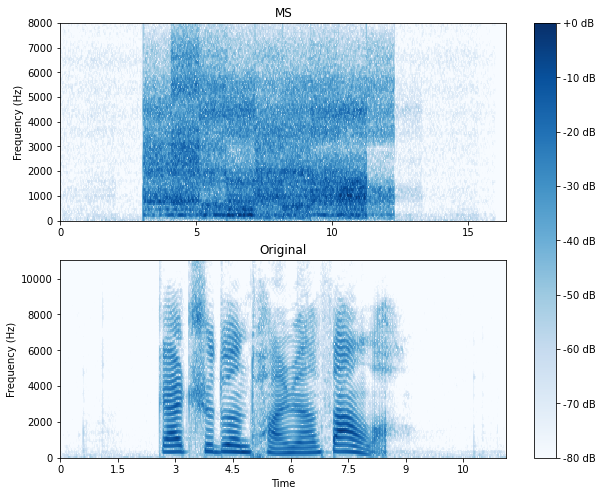

In [36]:
fig, ax = plt.subplots(2,1,figsize=(10, 8))
D_highres = librosa.stft(final, hop_length=40, n_fft=256)
S_db_hr = librosa.amplitude_to_db(np.abs(D_highres), ref=np.max)
img = librosa.display.specshow(S_db_hr, sr = 16000, hop_length=256, x_axis='time', y_axis='linear', cmap = 'Blues',
                               ax=ax[0])


D_highres = librosa.stft(x, hop_length=40, n_fft=256)
S_db_hr = librosa.amplitude_to_db(np.abs(D_highres), ref=np.max)
img = librosa.display.specshow(S_db_hr, hop_length=256, x_axis='time', y_axis='linear',cmap = 'Blues',
                               ax=ax[1])
ax[0].set(title='MS')
ax[1].set(title='Original')
ax[0].set_ylabel('Frequency (Hz)')
ax[1].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel(' ')
fig.colorbar(img, ax=ax, format="%+2.f dB")


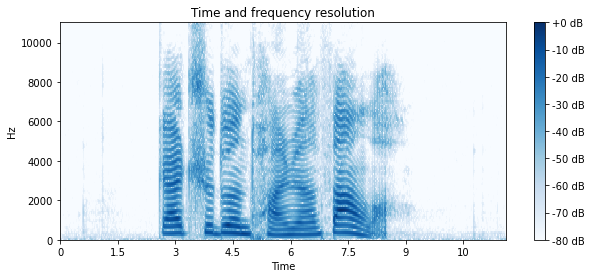

In [473]:
fig, ax = plt.subplots(figsize=(10, 4))
D_highres = librosa.stft(x, hop_length=40, n_fft=256)
S_db_hr = librosa.amplitude_to_db(np.abs(D_highres), ref=np.max)
img = librosa.display.specshow(S_db_hr, hop_length=256, x_axis='time', y_axis='linear',cmap = 'Blues',
                               ax=ax)
ax.set(title='original')
fig.colorbar(img, ax=ax, format="%+2.f dB")


# grid window was varied in 5 steps, 20, 40, 80, 160, and 320 ms, and the window edges were smoothed with 5-ms rise and fall times

# Seventeen frequency bands covering the range 0.1–4.4 kHz were utilized. This frequency range was enough to make noisevocoded speech almost perfectly intelligible

In [384]:
# By replacing each temporal segment of each critical band with a band noise portion of the same average intensity, mosaic speech was obtained

# the mosaic speech was constructed by # cutting the original speech as appeared in the spectrogram into time-by-frequency blocks of 80 ms and one critical bandwidth, and by leveling the sound-energy density in each block.

In [385]:
# From the information you've given, I'd use spectrogram A as the frequency data is spaced logarithmically. This is advantageous for pitch detection applications as it gives you a greater amount of resolution around the fundamental frequencies.




In [386]:
import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [387]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")


ModuleNotFoundError: No module named 'pyworld'